In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [32]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
/tmp/ipykernel_1142851/1719358244.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2016-01-05,AAPL,23.288244,25.677500,26.462500,25.602501,26.437500,223164000,-0.025059
5,2016-01-05,COKE,166.498184,176.740005,179.410004,174.300003,177.020004,32600,0.009655
6,2016-01-05,F,8.630340,13.720000,14.000000,13.510000,13.970000,50267500,-0.017895
7,2016-01-05,VZ,29.956114,46.500000,46.549999,45.630001,46.200001,15632800,0.013735
8,2016-01-06,AAPL,22.832506,25.174999,25.592501,24.967501,25.139999,273829600,-0.019569
...,...,...,...,...,...,...,...,...,...
8667,2024-08-13,VZ,40.779999,40.779999,40.799999,40.349998,40.650002,15349400,0.006168
8668,2024-08-14,AAPL,221.720001,221.720001,223.029999,219.699997,220.565002,39819528,0.002034
8669,2024-08-14,COKE,1258.170044,1258.170044,1270.122925,1247.569946,1254.000000,30443,0.003197
8670,2024-08-14,F,10.180000,10.180000,10.240000,10.050000,10.160000,36885523,0.003945


In [33]:
# Create assets dataframe

assets = df.groupby('Ticker')['Return'].mean().rename("Expected Return").to_frame().reset_index()

assets['Volatility'] = df.groupby('Ticker')['Return'].std().to_list()

assets['Sharpe Ratio'] = assets['Expected Return'] / assets['Volatility']

assets

,Ticker,Expected Return,Volatility,Sharpe Ratio
0,AAPL,0.001196,0.018284,0.065404
1,COKE,0.001226,0.023887,0.051322
2,F,0.000345,0.023562,0.014659
3,VZ,0.000227,0.012396,0.018290


In [34]:
# Returns dataframe
return_matrix = df[['Date','Ticker','Return']].pivot(index='Date', columns='Ticker', values='Return').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.025059,0.009655,-0.017895,0.013735
2016-01-06,-0.019569,0.018162,-0.044461,-0.009034
2016-01-07,-0.042205,-0.014004,-0.031274,-0.005492
2016-01-08,0.005288,0.002649,-0.012598,-0.009719
2016-01-11,0.016192,-0.029960,0.018341,0.005800
...,...,...,...,...
2024-08-08,0.016633,0.005090,0.036847,0.005958
2024-08-09,0.013736,-0.000333,-0.002961,0.005676
2024-08-12,0.007130,-0.004208,-0.023762,-0.005399


In [35]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[3.34290792e-04, 1.08434321e-04, 1.47068342e-04, 5.05549184e-05],
       [1.08434321e-04, 5.70597122e-04, 1.38300363e-04, 6.38495172e-05],
       [1.47068342e-04, 1.38300363e-04, 5.55187602e-04, 6.82637197e-05],
       [5.05549184e-05, 6.38495172e-05, 6.82637197e-05, 1.53659120e-04]])

In [36]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00119582, 0.00122593, 0.0003454 , 0.00022673])

In [37]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    port_std = portfolio_volatility(weights, cov_matrix)
    return -port_er / port_std

In [38]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [39]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_volatiliy = portfolio_volatility(initial_weights,cov_matrix)
port_sharpe = port_return / port_volatiliy

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Return: {round(port_return,2)} %")
print(f"Portfolio Volatility: {round(port_volatiliy,2)} %")
print(f"Portfolio Sharpe Ratio: {round(port_sharpe,2)}")

,Ticker,Weight
0,AAPL,0.25
1,COKE,0.25
2,F,0.25
3,VZ,0.25


Portfolio Return: 0.0 %
Portfolio Volatility: 0.01 %
Portfolio Sharpe Ratio: 0.06


In [40]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((-1, 1) for _ in range(len(tickers)))  # each weight between -1 and 1

# Result
result = minimize(negative_sharpe_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

optimal_weights

array([ 0.76735815,  0.39000735, -0.15503371, -0.00233179])

In [41]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_volatility = portfolio_volatility(optimal_weights,cov_matrix)
opt_port_sharpe_ratio = opt_port_return / opt_port_volatility

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {round(opt_port_return,2)} %")
print(f"Optimized Portfolio Volatility: {round(opt_port_volatility,2)} %")
print(f"Optimized Portfolio Sharpe Ratio: {round(opt_port_sharpe_ratio,2)}")

,Ticker,Weight
0,AAPL,0.77
1,COKE,0.39
2,F,-0.16
3,VZ,-0.00


Optimized Portfolio Return: 0.0 %
Optimized Portfolio Volatility: 0.02 %
Optimized Portfolio Sharpe Ratio: 0.08


In [42]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((-1, 1) for _ in range(len(tickers)))

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [43]:
# Pro
n_points = 100
target_returns = np.linspace(0,2*opt_port_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
volatilities = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Return'] = returns
portfolios['Volatility'] = volatilities
portfolios['Sharpe Ratio'] = portfolios['Expected Return'] / portfolios['Volatility']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Return,Volatility,Sharpe Ratio
0,Portfolio 1,-0.16,-0.10,0.26,1.00,9.494139e-14,0.014036,6.764269e-12
1,Portfolio 2,-0.15,-0.08,0.23,1.00,2.710434e-05,0.013712,1.976683e-03
2,Portfolio 3,-0.13,-0.07,0.20,1.00,5.420869e-05,0.013420,4.039472e-03
3,Portfolio 4,-0.11,-0.06,0.18,0.99,8.131303e-05,0.013158,6.179733e-03
4,Portfolio 5,-0.09,-0.05,0.17,0.97,1.084174e-04,0.012912,8.396831e-03
...,...,...,...,...,...,...,...,...
95,Portfolio 96,1.00,1.00,0.00,-1.00,2.195019e-03,0.032351,6.784949e-02
96,Portfolio 97,1.00,1.00,-0.00,-1.00,2.195019e-03,0.032351,6.784949e-02
97,Portfolio 98,1.00,1.00,0.00,-1.00,2.195019e-03,0.032351,6.784949e-02
98,Portfolio 99,1.00,1.00,-0.00,-1.00,2.195019e-03,0.032351,6.784949e-02


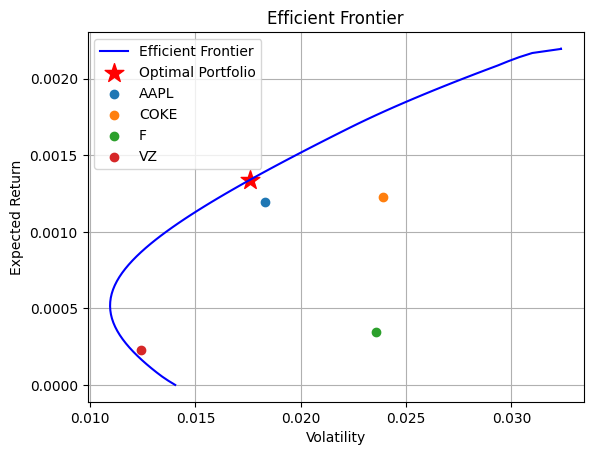

In [44]:
plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_volatility, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Expected Return'].iloc[i], label=ticker)

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

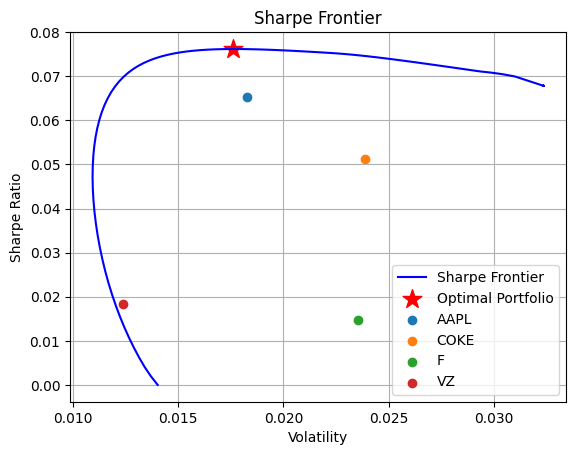

In [45]:
# Sharpe Graph
plt.plot(portfolios['Volatility'], portfolios['Sharpe Ratio'], 'b-', label='Sharpe Frontier')
plt.scatter(opt_port_volatility, opt_port_sharpe_ratio, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Sharpe Ratio'].iloc[i], label=ticker)

    
plt.xlabel('Volatility')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Frontier')
plt.legend()
plt.grid(True)
plt.show()